# TP 2 : Computer Vision

## Part 1 : segmentation

#### Done by Siwar ABBES


In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

(800, 586)

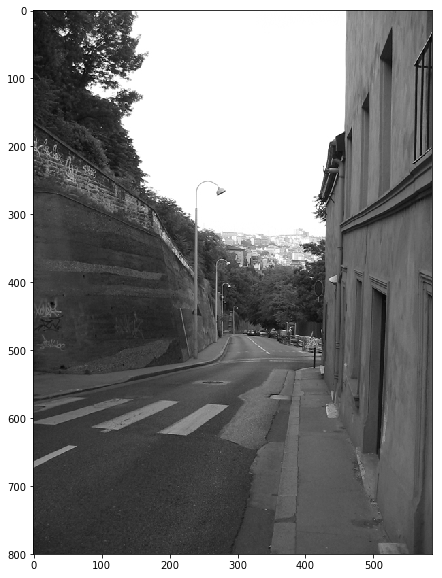

In [2]:
display_image(img_gray)

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and 

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and 

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions : you cannot have a region with no pixels. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [3]:
# This function returns the segmentation of the algorithm of otsu, as well as the threshold found
def segmentation_otsu(img):
    
    seg_otstu_out = img.copy()
    tau_out = 0
    c_max = np.float('inf')
    
    for i in np.linspace(0,1,256):
                
        w0 = np.sum(img <=i)
        w1 = np.sum(img >i)
        
        reg0 = img[img <= i].flatten() 
        reg1 = img[img > i].flatten()

        if reg0.sum()!=0 and reg1.sum()!=0:
            v0 = np.var(reg0)
            v1 = np.var(reg1)
        
            cost = w0 * v0 +  w1 * v1
        
            if cost < c_max :
                tau_out = i
                c_max = cost
    
    seg_otstu_out[img > tau_out] = 1
    seg_otstu_out[img < tau_out] = 0
    
    return seg_otstu_out,tau_out

#### Other method which is faster


In [4]:
def segmentation_otsu_hist(img):
    
    pixel_number = img.shape[0] * img.shape[1]
    mean_weigth = 1.0 / pixel_number
    seg_otstu_out = img.copy()
    his, bins = np.histogram(img, np.array(range(0, 256)))
    tau_out = -1
    c_max = -1
    
    for i in bins[1:-1]: 
        W0 = np.sum(his[:i]) * mean_weigth
        W1 = np.sum(his[i:]) * mean_weigth

        mu0 = np.mean(his[:i])
        mu1 = np.mean(his[i:])

        cost = W0 * W1 * (mu0 - mu1) ** 2

        if cost > c_max:
            tau_out = i
            c_max = cost
            
    seg_otstu_out[img > tau_out] = 1
    seg_otstu_out[img < tau_out] = 0
    
    
    return seg_otstu_out,tau_out

Carry out the segmentation on the input image and display the result

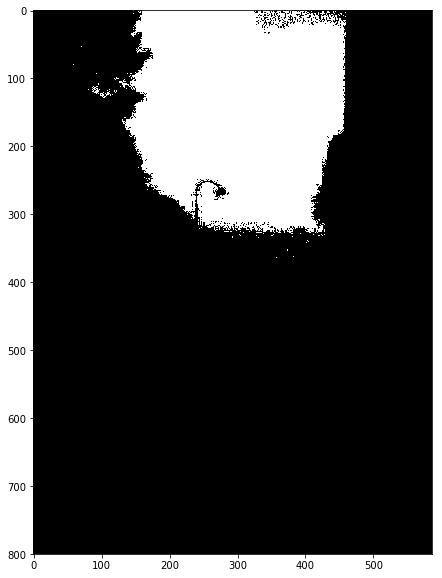

In [5]:
img_out_otsu,tau = segmentation_otsu_hist(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

__Question__ What problem can you see with the segmentation result ? What morphological technique(s) (seen in the lesson) could you use to clean the result up ? 

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER</span> <br><br>

As we can see, the problem of Otsu’s method is that segmented objects (like the lamp) may not be connected as we use a global threshold.

To deal with these issues, we can use these morphological techniques :
 - Opening: Used to remove small objects in binary images (similar to denoising)
 - Closing: Used to fill small holes in binary images

Carry out this technique to clean up the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

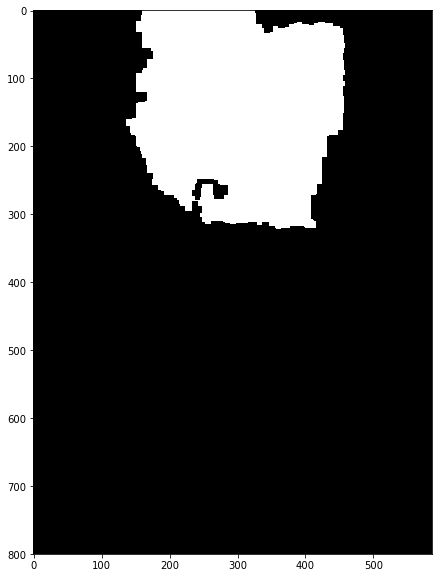

In [6]:
from skimage.morphology import opening, closing

struct_size = 7
struct_el = np.ones((struct_size,struct_size))
img_out_otsu_cleaned = closing(opening(img_out_otsu,struct_el),struct_el)

display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

__Question__ In which order did you propose to carry out the morphological operations ? Why ?

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER</span> <br><br>

In image processing, closing is, together with opening, the basic workhorse of morphological noise removal. As we mentioned before, opening removes small objects, while closing removes small holes. Here, when we try to choose the appropriate neighbourhood parameter, we get two distinct regions with no holes and no separated small objects.


Let's change the image, and carry out the segmentation again.

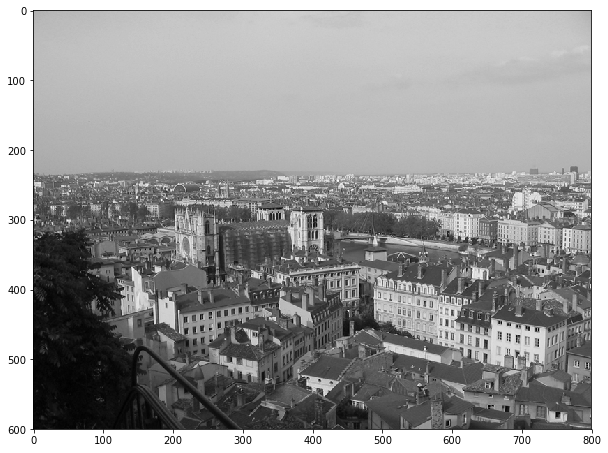

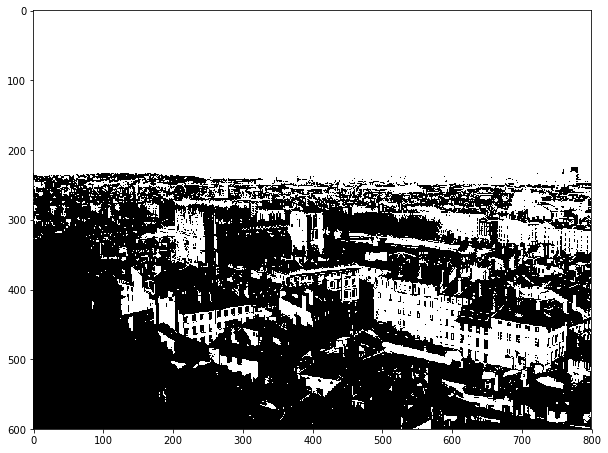

In [7]:
file_name = 'town'
file_ext = '.png'
img_gray2,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray2)
img_gray2.shape

img_out_otsu2,tau = segmentation_otsu(img_gray2)
display_image(img_out_otsu2)
write_image(img_out_otsu2,file_name+'_segmentation_otsu.png')

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">COMMENT</span> <br><br>
As we can remark here , there is an absence of connectivity in the algorithm of Otsu. In fact, two regions far away may not be in the same segment. 

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add new pixels progressively to the region. More precisely, at each iteration of the algorithm, we attempt to add the neighbours of the pixels in the current segmentation. We add new pixels according to the criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [8]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    seg_size = 5
    x = np.ones(img_shape)
    x[seed_pt] = 0
    dist = distance_transform_edt(x)
    seg_init = np.where(dist < seg_size, 1, 0)
    # FILL IN CODE HERE 
    return seg_init


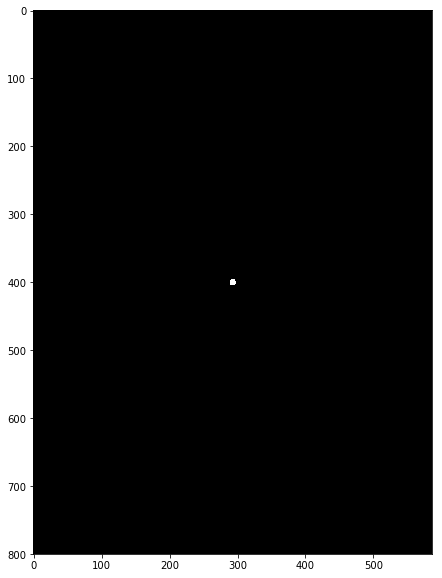

In [9]:
img_shape = img_gray.shape
seed_pt = img_shape[0]//2, img_shape[1]//2
seg_init = initialize_segmentation((seed_pt),img_shape)
display_image(seg_init)

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

__IMPORTANT NOTE__ Once a pixel has been added to the region, it is in the region permanently : it is not checked again in further iterations (otherwise we could remove pixels which were added).

In [10]:
from scipy.ndimage import binary_dilation

# This function returns both the final segmentation and the initialisation
def segmentation_region_growing(img,seed_pt,tau):

    # FILL IN CODE HERE
    img_shape = img.shape
    seg_init = initialize_segmentation(seed_pt,img.shape)  
    still_growing = True
    R = np.copy(seg_init)
    seg = np.zeros(img_shape)
    
    while still_growing:
        
        still_growing = False
        mu = np.mean(img[R==1])
        dilation = binary_dilation(R) - R
        dilation_index = np.where(dilation==1)
        for l in range(len(dilation_index[0])):
            i = dilation_index[0][l]
            j = dilation_index[1][l]
            if (np.abs(img[i,j]-mu)<tau):
                R[i,j] = 1
                still_growing = True
    
    seg[R==1] = 1
    
    return seg,seg_init

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

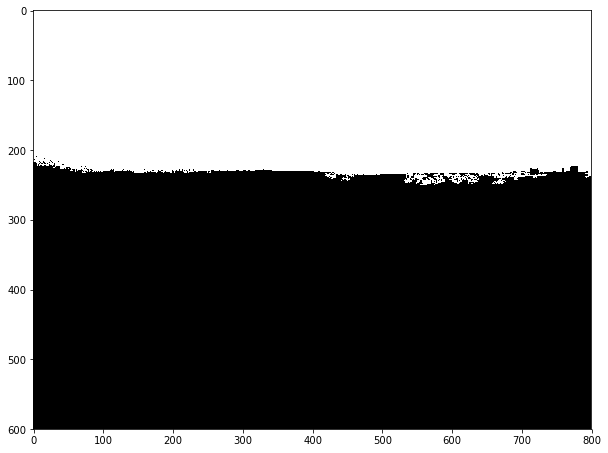

In [11]:
seed_pt = 130,350
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray2,seed_pt,tau)
display_image(img_out_region_growing)
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')

Let's see the result on the first image: 

In [ ]:
seed_pt = img_shape[0]//4, img_shape[1]//3
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)
display_image(img_out_region_growing)
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">COMMENT</span> <br><br>
As we can see, the segmentation is done perfectly, even two connected regions far away are in the same segment.